In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm

from scipy.special import expit

In [2]:
%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-darkgrid")
rng = np.random.default_rng(1234)

In [3]:
# true params
beta0_true = 0.7
beta1_true = 0.4
# number of yes/no questions
n = 20

sample_size = 30
x = np.linspace(-10, 20, sample_size)
# Linear model
mu_true = beta0_true + beta1_true * x
# transformation (inverse logit function = expit)
p_true = expit(mu_true)
# Generate data
y = rng.binomial(n, p_true)
# bundle data into dataframe
data = pd.DataFrame({"x": x, "y": y})

In [4]:
data.head()

,x,y
0,-10.000000,3
1,-8.965517,1
2,-7.931034,3
3,-6.896552,1
4,-5.862069,2


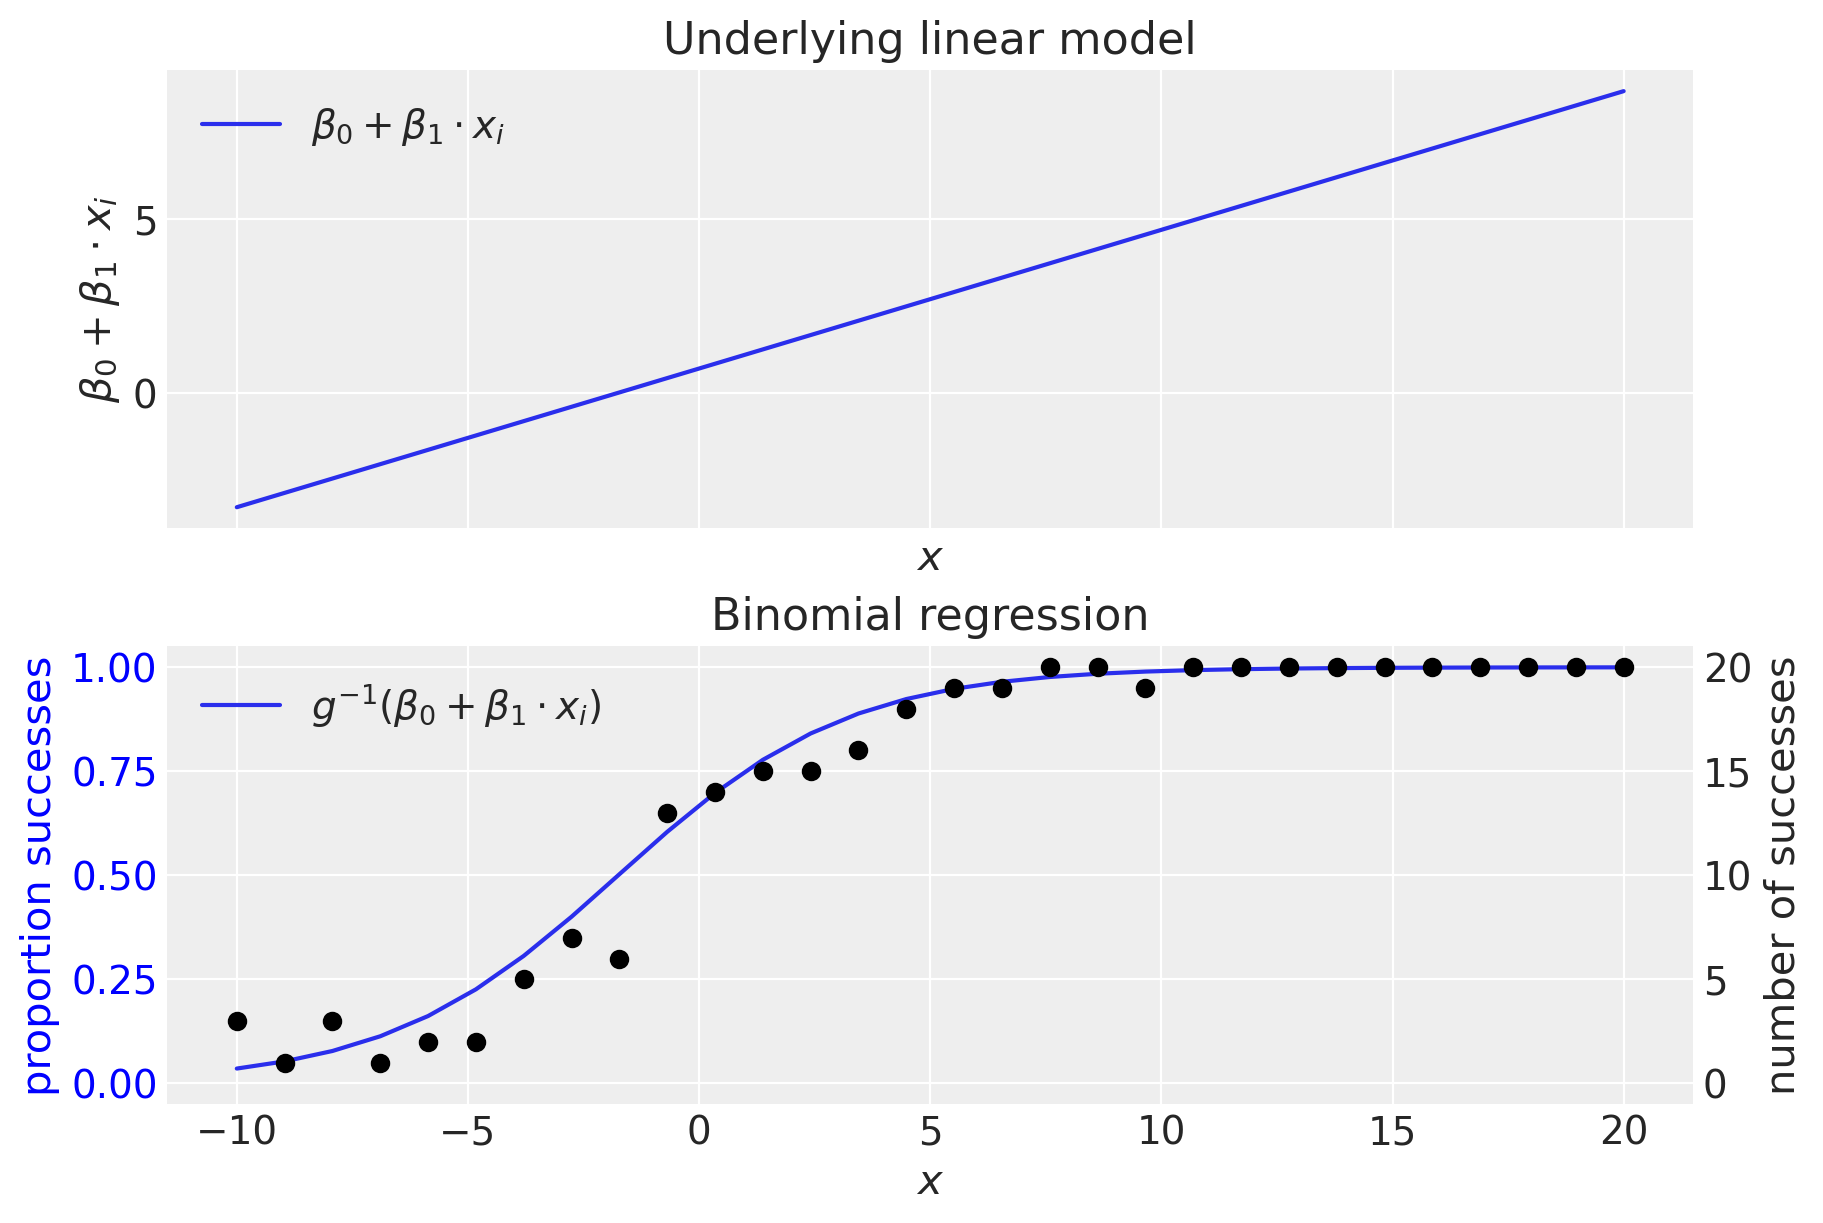

In [5]:
# Plot underlying linear model
fig, ax = plt.subplots(2, 1, figsize=(9, 6), sharex=True)
ax[0].plot(x, mu_true, label=r"$β_0 + β_1 \cdot x_i$")
ax[0].set(xlabel="$x$", ylabel=r"$β_0 + β_1 \cdot x_i$", title="Underlying linear model")
ax[0].legend()

# Plot GLM
freq = ax[1].twinx()  # instantiate a second axes that shares the same x-axis
freq.set_ylabel("number of successes")
freq.scatter(x, y, color="k")
# plot proportion related stuff on ax[1]
ax[1].plot(x, p_true, label=r"$g^{-1}(β_0 + β_1 \cdot x_i)$")
ax[1].set_ylabel("proportion successes", color="b")
ax[1].tick_params(axis="y", labelcolor="b")
ax[1].set(xlabel="$x$", title="Binomial regression")
ax[1].legend()
# get y-axes to line up
y_buffer = 1
freq.set(ylim=[-y_buffer, n + y_buffer])
ax[1].set(ylim=[-(y_buffer / n), 1 + (y_buffer / n)])
freq.grid(None)

In [6]:
coords = {"observation": data.index.values}

with pm.Model(coords=coords) as binomial_regression_model:
    x = pm.ConstantData("x", data["x"], dims="observation")
    # priors
    beta0 = pm.Normal("beta0", mu=0, sigma=1)
    beta1 = pm.Normal("beta1", mu=0, sigma=1)
    # linear model
    mu = beta0 + beta1 * x
    p = pm.Deterministic("p", pm.math.invlogit(mu), dims="observation")
    # likelihood
    pm.Binomial("y", n=n, p=p, observed=data["y"], dims="observation")

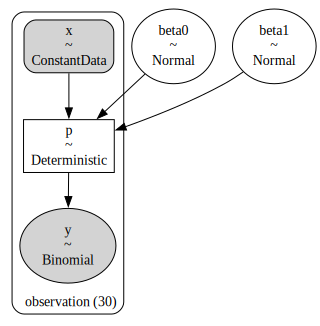

In [8]:
pm.model_to_graphviz(binomial_regression_model)

In [9]:
with binomial_regression_model:
    idata = pm.sample(1000, tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta0, beta1]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 28 seconds.


array([[<AxesSubplot: title={'center': 'beta0'}>,
        <AxesSubplot: title={'center': 'beta0'}>],
       [<AxesSubplot: title={'center': 'beta1'}>,
        <AxesSubplot: title={'center': 'beta1'}>]], dtype=object)

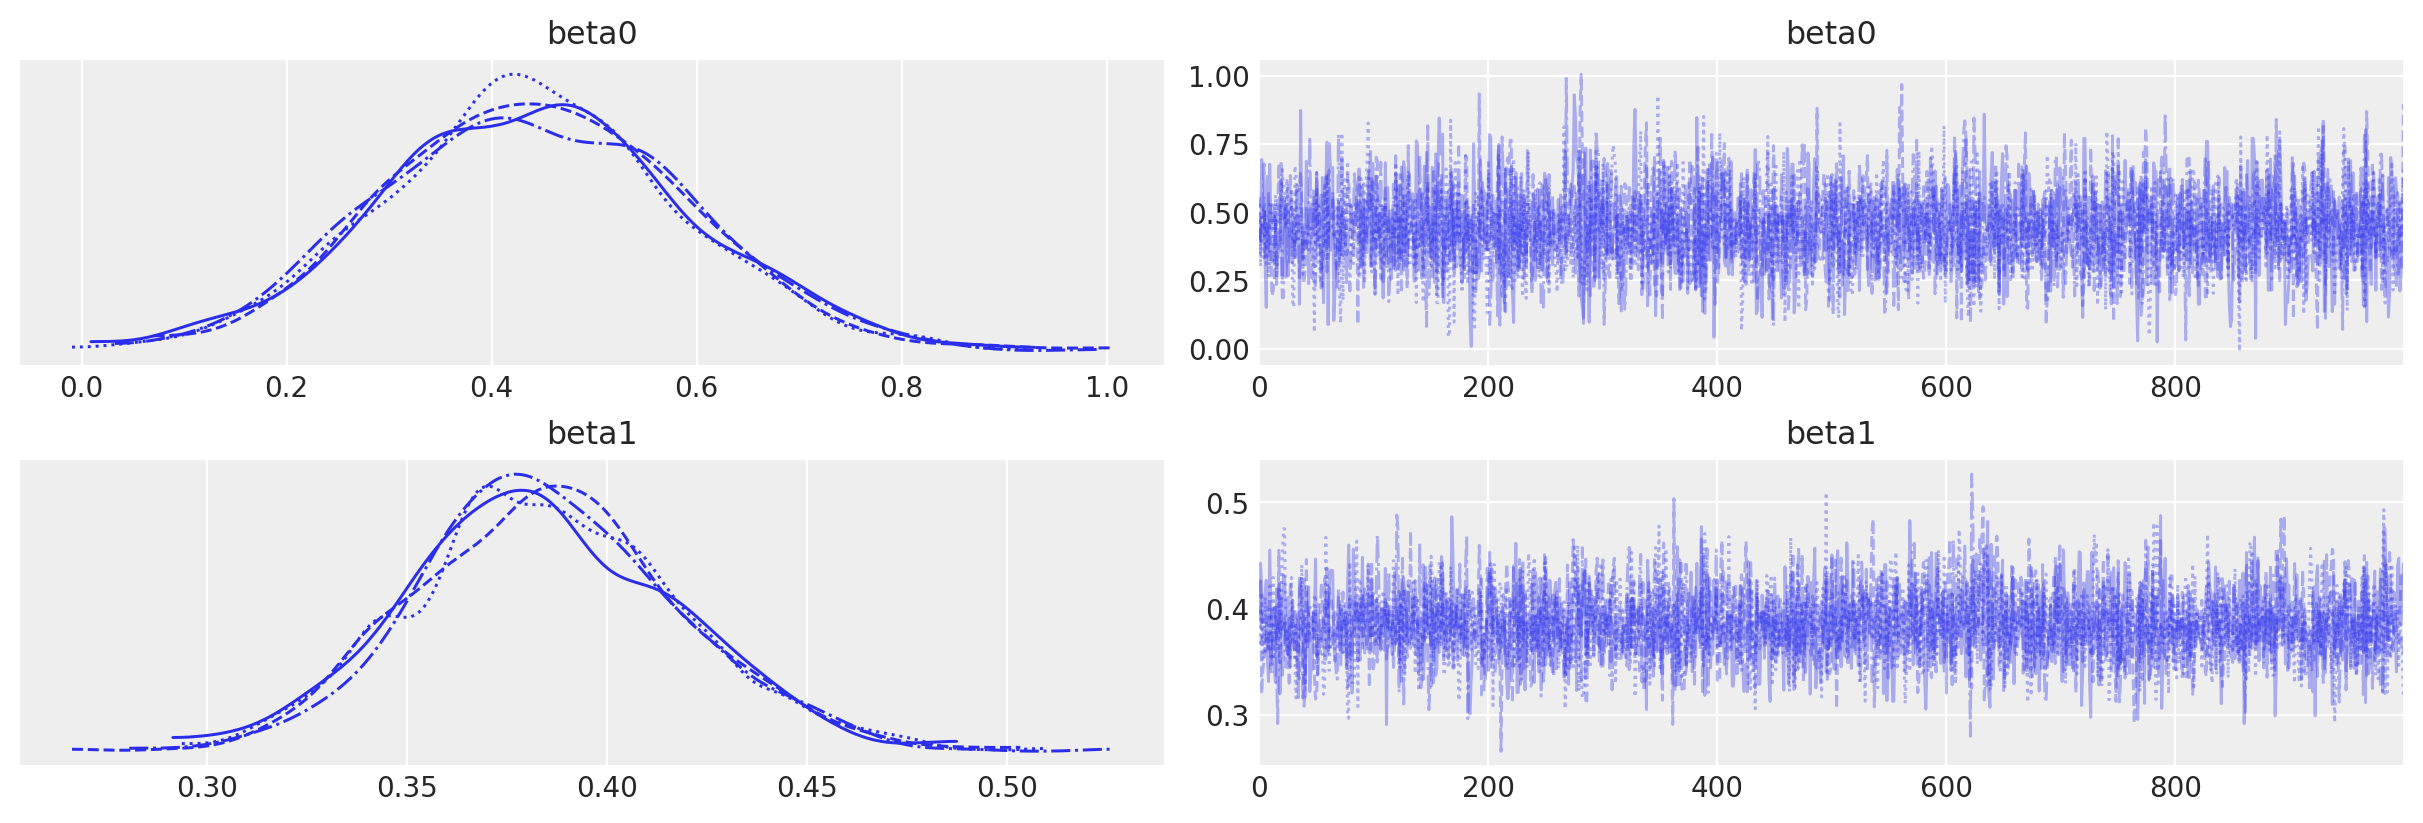

In [10]:
az.plot_trace(idata, var_names=["beta0", "beta1"])

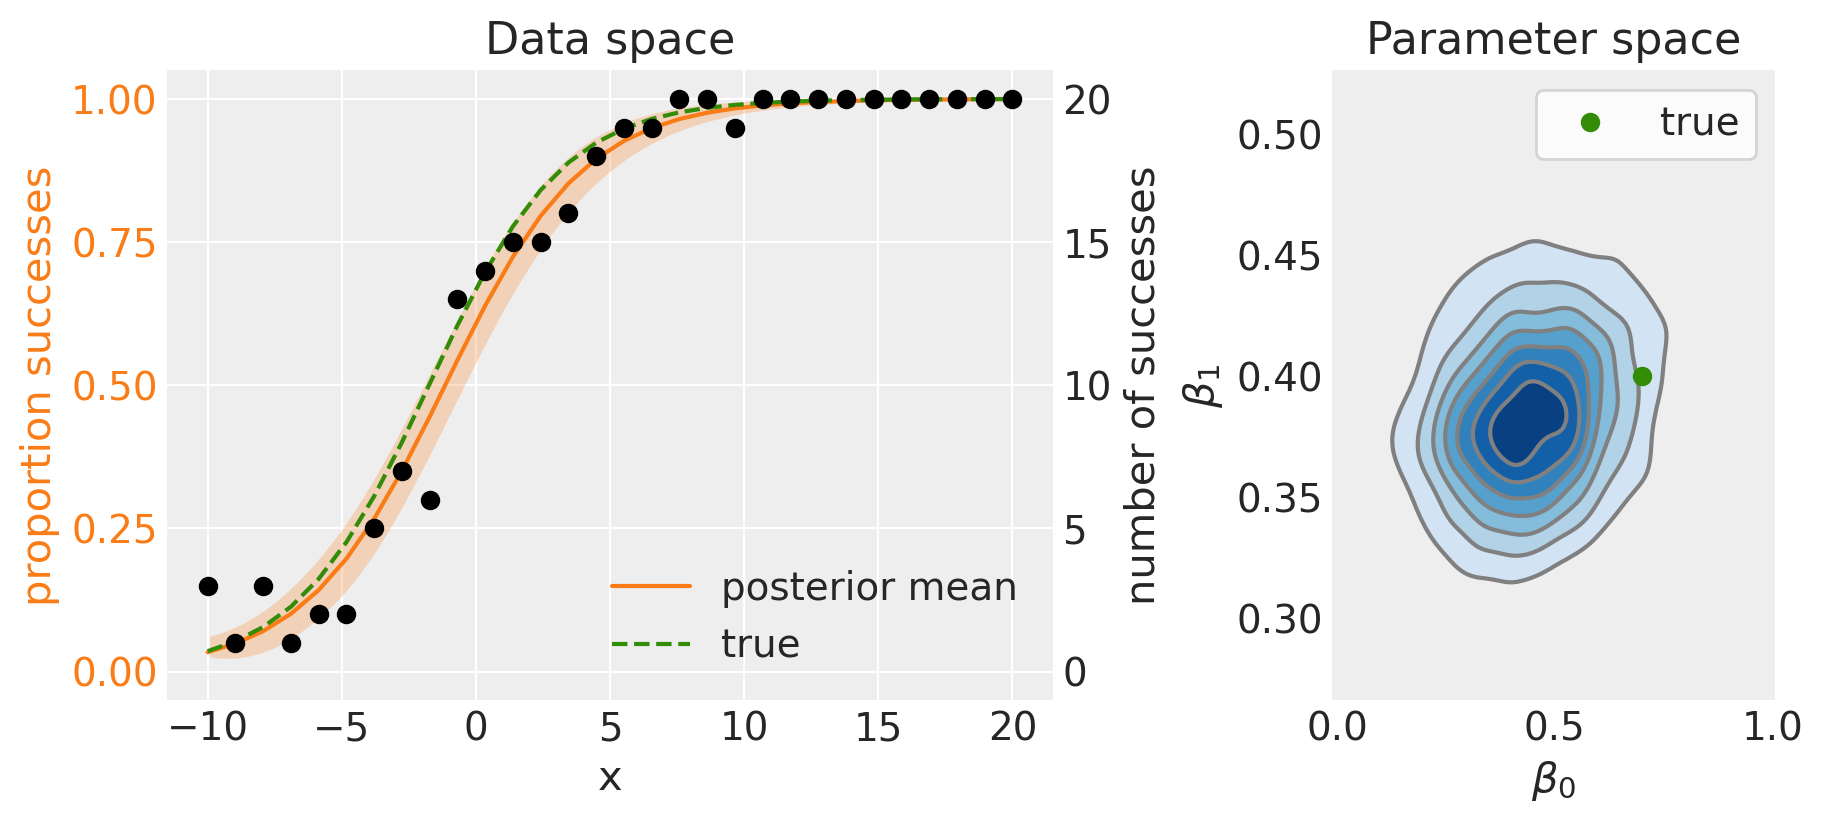

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(9, 4), gridspec_kw={"width_ratios": [2, 1]})

# Data space plot ========================================================
az.plot_hdi(
    data["x"],
    idata.posterior.p,
    hdi_prob=0.95,
    fill_kwargs={"alpha": 0.25, "linewidth": 0},
    ax=ax[0],
    color="C1",
)
# posterior mean
post_mean = idata.posterior.p.mean(("chain", "draw"))
ax[0].plot(data["x"], post_mean, label="posterior mean", color="C1")
# plot truth
ax[0].plot(data["x"], p_true, "--", label="true", color="C2")
# formatting
ax[0].set(xlabel="x", title="Data space")
ax[0].set_ylabel("proportion successes", color="C1")
ax[0].tick_params(axis="y", labelcolor="C1")
ax[0].legend()
# instantiate a second axes that shares the same x-axis
freq = ax[0].twinx()
freq.set_ylabel("number of successes")
freq.scatter(data["x"], data["y"], color="k", label="data")
# get y-axes to line up
y_buffer = 1
freq.set(ylim=[-y_buffer, n + y_buffer])
ax[0].set(ylim=[-(y_buffer / n), 1 + (y_buffer / n)])
freq.grid(None)
# set both y-axis to have 5 ticks
ax[0].set(yticks=np.linspace(0, 20, 5) / n)
freq.set(yticks=np.linspace(0, 20, 5))

# Parameter space plot ===================================================
az.plot_kde(
    idata.posterior.stack(sample=("chain", "draw")).beta0.values,
    idata.posterior.stack(sample=("chain", "draw")).beta1.values,
    contourf_kwargs={"cmap": "Blues"},
    ax=ax[1],
)
ax[1].plot(beta0_true, beta1_true, "C2o", label="true")
ax[1].set(xlabel=r"$\beta_0$", ylabel=r"$\beta_1$", title="Parameter space")
ax[1].legend(facecolor="white", frameon=True);